# Build Crude Oil Price Forecasting Models with LSTM

In [17]:
# import standard libraries
import numpy as np
import pandas as pd
import glob
import math
import time
import os

import warnings
warnings.filterwarnings("ignore")

import datetime
from datetime import date, timedelta


## import statistical library
from scipy.stats import spearmanr
import scipy.stats as stats
from scipy.stats import lognorm


# import viz libraries
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline


# import model libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.utils.vis_utils import plot_model
from keras.regularizers import l2
from keras.constraints import max_norm

In [18]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

In [19]:
today_date = date.today()
days = pd.date_range(start=today_date, periods=14)
yesterday = today_date - timedelta(days=1)
yesterday = yesterday.strftime("%Y-%m-%d")
today_date = today_date.strftime("%Y-%m-%d")

## Buat LSTM untuk Crude Oil Price

In [20]:
# set file path
crude = "../historical-dataset/Crude Oil Prices.csv"

# load dataset
main_crude = pd.read_csv(crude, parse_dates=["Date"], index_col=["Date"]).sort_index(ascending=True)

In [21]:
# display first five rows
main_crude.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
1994-01-03,14.56,14.10,14.65,14.11,37.38K,2.75%
1994-01-04,14.67,14.55,14.72,14.35,37.75K,0.76%
1994-01-05,15.34,14.50,15.42,14.65,69.69K,4.57%
1994-01-06,15.42,15.34,15.61,15.05,51.95K,0.52%
1994-01-07,15.32,15.40,15.46,15.23,31.71K,-0.65%


In [22]:
main_crude = main_crude[:yesterday]
main_crude.tail()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2022-12-09,71.50,72.07,72.92,70.11,NaN,-0.78%
2022-12-11,71.90,71.78,72.31,71.65,NaN,0.56%
2022-12-12,73.74,71.89,73.98,70.25,NaN,2.56%
2022-12-13,74.00,73.42,74.20,73.31,NaN,+0.76%
2022-12-14,76.14,75.19,76.49,74.91,NaN,+1.26%


In [23]:
# extract close price
df = main_crude.reset_index()["Price"]
df.shape

(7383,)

In [24]:
# normalize
scaler = MinMaxScaler(feature_range=(0,1))
df = scaler.fit_transform(np.array(df).reshape(-1,1))

df

array([[0.28531599],
       [0.28591734],
       [0.28958014],
       ...,
       [0.6088454 ],
       [0.61026678],
       [0.62196589]])

Splitting data for training and testing

In [25]:
train_size = int(len(df)*0.65)
test_size = len(df) - train_size
train_data, test_data = df[0:train_size,:], df[train_size:len(df),:1]
len(train_data), len(test_data)

(4798, 2585)

Preprocessing

In [26]:
def create_data_matrix(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [27]:
time_step = 120
X_train, y_train = create_data_matrix(train_data, time_step)
X_test, y_valid = create_data_matrix(test_data, time_step)

In [28]:
print(X_train.shape), print(y_train.shape)
print(X_test.shape), print(y_train.shape)

(4677, 120)
(4677,)
(2464, 120)
(4677,)


(None, None)

In [29]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

Build LSTM Model

`In this example, the LSTM layer has 100 units, and the weights of the recurrent connections are regularized using the L2 regularization with a weight of 0.01. The weights are also constrained to have a maximum norm of 1.0.

You can adjust these parameters to suit your specific needs and problem. For example, you can try using different regularization methods, such as L1 regularization or a combination of L1 and L2 regularization, and you can experiment with different weight constraints to see what works best for your model.`

In [30]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(120,1), recurrent_regularizer=l2(0.01), recurrent_constraint=max_norm(1.0)))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 120, 100)          40800     
                                                                 
 lstm_4 (LSTM)               (None, 120, 100)          80400     
                                                                 
 lstm_5 (LSTM)               (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 201,701
Trainable params: 201,701
Non-trainable params: 0
_________________________________________________________________


In [32]:
history = model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1, validation_split=0.2, validation_data=(X_test, y_valid))

Epoch 1/100
74/74 [==============================] - 51s 557ms/step - loss: 0.0098 - val_loss: 6.8276e-04
Epoch 2/100
74/74 [==============================] - 57s 772ms/step - loss: 3.8993e-04 - val_loss: 0.0011
Epoch 3/100
74/74 [==============================] - 56s 758ms/step - loss: 4.0760e-04 - val_loss: 6.2977e-04
Epoch 4/100
74/74 [==============================] - 51s 691ms/step - loss: 3.5606e-04 - val_loss: 7.8566e-04
Epoch 5/100
74/74 [==============================] - 46s 624ms/step - loss: 3.3497e-04 - val_loss: 4.6238e-04
Epoch 6/100
74/74 [==============================] - 41s 558ms/step - loss: 3.6072e-04 - val_loss: 4.5648e-04
Epoch 7/100
74/74 [==============================] - 37s 496ms/step - loss: 3.1750e-04 - val_loss: 4.9990e-04
Epoch 8/100
74/74 [==============================] - 36s 483ms/step - loss: 2.9138e-04 - val_loss: 4.8196e-04
Epoch 9/100
74/74 [==============================] - 39s 526ms/step - loss: 3.0729e-04 - val_loss: 3.8330e-04
Epoch 10/100
74/74

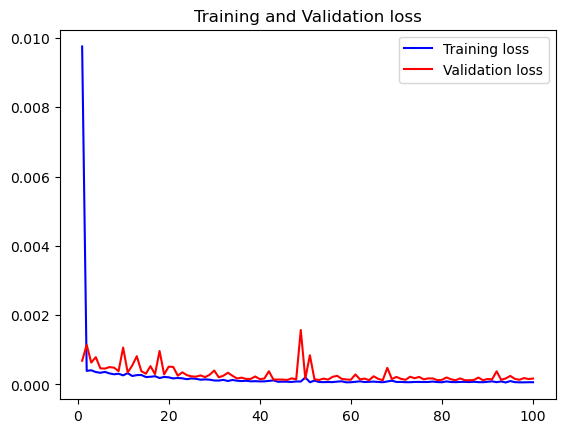

In [33]:
# viz loss
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)

# train - validation loss 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.savefig('../figures/train-and-val-loss-crude.jpg')
plt.show()

In [34]:
# save model
model.save("../models/crude-oil-model.h5")

predict on training - test data

In [35]:
# load model
use_model = load_model("../models/crude-oil-model.h5")

In [36]:
# predict and check performance metrics
train_predict=use_model.predict(X_train)
test_predict=use_model.predict(X_test)

77/77 [==============================] - 5s 64ms/step


In [37]:
train_rmse = math.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = math.sqrt(mean_squared_error(y_valid, test_predict))

print("train rmse: ", train_rmse)
print("test rmse: ", test_rmse)

train rmse:  0.009690349240488342
test rmse:  0.012976228643150437


In [38]:
# transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

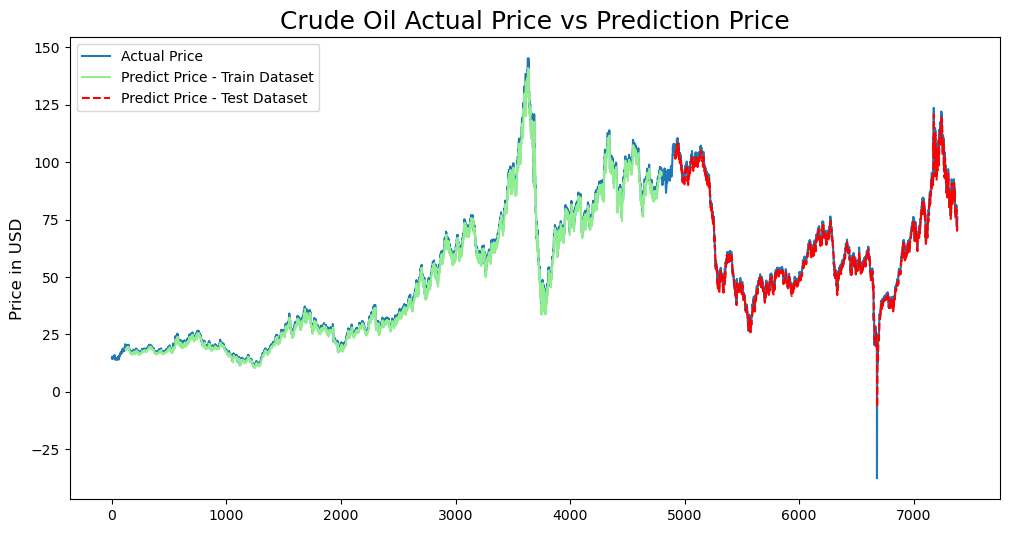

In [39]:
# plotting
plt.gcf().set_size_inches(12, 6, forward=True)
currentFig = plt.gcf()


trainPredictPlot = np.empty_like(df)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[time_step:len(train_predict)+time_step, :] = train_predict

testPredictPlot = np.empty_like(df)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+time_step*2 + 1: len(df)-1, :] = test_predict

plt.plot(scaler.inverse_transform(df), label="Actual Price")
plt.plot(trainPredictPlot, label="Predict Price - Train Dataset", color="lightgreen")
plt.plot(testPredictPlot, label="Predict Price - Test Dataset", color="r", linestyle="dashed")

# styling
currentFig.set_facecolor('white')
plt.legend()
plt.ylabel('Price in USD', fontsize=12)
plt.title('Crude Oil Actual Price vs Prediction Price', fontsize=18)

plt.savefig('../figures/lstm-performance-prediction-results.jpg')
plt.show()